In [306]:
import pybiomart
import pandas, scipy, numpy
import matplotlib, matplotlib.pyplot as plt

In [287]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [288]:
matplotlib.rcParams.update({'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                            'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',
                            'figure.figsize':(8, 5), 'svg.fonttype' : 'none'})

In [289]:
file_directory = "/Users/kja11/OneDrive - Menntaský/PostDoc_Hypothermia/in_silico/Python/"

# II] Data Download

In [290]:
# Import data from hsapiens_gene_ensembl
dataset = pybiomart.Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')
annotation = dataset.query(attributes=['external_gene_name', 'external_transcript_name', 'ensembl_gene_id', 'ensembl_transcript_id',
                                       'gene_biotype', 'transcript_biotype', 'description'])

annotation = annotation.rename(columns = {'Gene stable ID' : 'gene_id',
                                   'Transcript stable ID' : 'transcript_id'})

annotation.set_index('transcript_id', drop=True, inplace=True)
# annotation.set_index('Gene stable ID', inplace=True)
annotation.head(2)

,Gene name,Transcript name,gene_id,Gene type,Transcript type,Gene description
transcript_id,,,,,,
ENST00000387314,MT-TF,MT-TF-201,ENSG00000210049,Mt_tRNA,Mt_tRNA,mitochondrially encoded tRNA-Phe (UUU/C) [Sour...
ENST00000389680,MT-RNR1,MT-RNR1-201,ENSG00000211459,Mt_rRNA,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:HGNC ...


In [291]:
#data all_counts_filtered
df = pandas.read_csv(file_directory+'1) input/HEK293_temp_transcript_all_counts_filtered.tsv',
                     sep = '\t')
print(df.shape)
df.head()

(90972, 8)


,gene_id,feature_id,s37rep1,s37rep2,s37rep3,s32rep1,s32rep2,s32rep3
1,ENSG00000198034,ENST00000486733,1039,1280,938,652,834,633
2,ENSG00000198034,ENST00000492695,209,202,105,66,69,46
3,ENSG00000198034,ENST00000470671,61,75,76,50,76,54
4,ENSG00000182774,ENST00000558397,59427,72460,59413,51375,60020,63185
5,ENSG00000182774,ENST00000561068,12382,15089,11258,9856,12745,12056


# III] Data transformation

In [292]:
df = df.rename(columns = {'feature_id' : 'transcript_id'})
df.set_index('transcript_id', drop=True, inplace=True)
df = df.drop('gene_id', axis=1)
df.head()

,s37rep1,s37rep2,s37rep3,s32rep1,s32rep2,s32rep3
transcript_id,,,,,,
ENST00000486733,1039,1280,938,652,834,633
ENST00000492695,209,202,105,66,69,46
ENST00000470671,61,75,76,50,76,54
ENST00000558397,59427,72460,59413,51375,60020,63185
ENST00000561068,12382,15089,11258,9856,12745,12056


In [293]:
# Remove the non expressed transcripts (less than 10 counts)
full_leng = len(df)
df = df[df.max(axis=1) >= 10]

filtr_leng = len(df)
dropped_transcripts = full_leng - filtr_leng

print(f'On {full_leng}, {dropped_transcripts} transcripts do not exceed 10 counts')

df = df.T
df

On 90972, 32533 transcripts do not exceed 10 counts


transcript_id,ENST00000486733,ENST00000492695,ENST00000470671,ENST00000558397,ENST00000561068,ENST00000560612,ENST00000560229,ENST00000559776,ENST00000372209,ENST00000464658,...,ENST00000225740,ENST00000457500,ENST00000444455,ENST00000464295,ENST00000495912,ENST00000445170,ENST00000296438,ENST00000381938,ENST00000596399,ENST00000221973
s37rep1,1039,209,61,59427,12382,241,59,49,8623,4668,...,0,0,0,0,0,0,0,0,0,0
s37rep2,1280,202,75,72460,15089,305,80,47,12461,7714,...,3,3,3,2,1,1,1,1,0,0
s37rep3,938,105,76,59413,11258,233,59,44,9165,4999,...,10,10,10,1,1,4,9,4,6,6
s32rep1,652,66,50,51375,9856,180,51,31,8030,4257,...,9,10,9,2,4,10,10,4,0,0
s32rep2,834,69,76,60020,12745,245,72,53,10030,5690,...,13,15,13,11,10,3,5,10,12,12
s32rep3,633,46,54,63185,12056,198,59,32,10273,5280,...,6,6,6,3,2,0,0,5,6,6


In [294]:
metadata = pandas.DataFrame(zip(df.index, ['37°','37°','37°','32°', '32°', '32°']),
                            columns = ['Sample', 'Condition'])

metadata = metadata.set_index('Sample')
metadata

,Condition
Sample,
s37rep1,37°
s37rep2,37°
s37rep3,37°
s32rep1,32°
s32rep2,32°
s32rep3,32°


In [298]:
%%time
# define the data
dds = DeseqDataSet(counts = df,
                   metadata = metadata,
                   design_factors = "Condition")
print(dds)

#run deseq2
dds.deseq2()

#show results
stat_res = DeseqStats(dds, contrast = ('Condition', '32°', '37°'))

AnnData object with n_obs × n_vars = 6 × 58439
    obs: 'Condition'
    obsm: 'design_matrix'


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 21.61 seconds.

Fitting dispersion trend curve...
... done in 2.35 seconds.

Fitting MAP dispersions...
... done in 16.05 seconds.

Fitting LFCs...
... done in 9.68 seconds.

Refitting 0 outliers.



AttributeError: 'DeseqStats' object has no attribute 'results_df'

In [302]:
#save results in a df
res = stat_res.results_df
res

stat_res.summary()
stat_res.results_df

#save results in a df
res = stat_res.results_df
res

Log2 fold change & Wald test p-value: Condition 32° vs 37°
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
transcript_id                                                                 
ENST00000486733    860.709140       -0.242495  0.224805 -1.078690  0.280726   
ENST00000492695    105.507348       -1.113104  0.300950 -3.698630  0.000217   
ENST00000470671     64.387535        0.117380  0.336456  0.348872  0.727185   
ENST00000558397  60609.524192        0.261620  0.242474  1.078960  0.280606   
ENST00000561068  12080.262313        0.234485  0.235375  0.996219  0.319144   
...                       ...             ...       ...       ...       ...   
ENST00000445170      3.099013        1.575675  1.352003  1.165438  0.243842   
ENST00000296438      4.287670        0.719877  1.233849  0.583440  0.559597   
ENST00000381938      4.294933        2.197738  1.102355  1.993676  0.046187   
ENST00000596399      4.344494        1.710364  2.900967  0.589584  0.555

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
transcript_id,,,,,,
ENST00000486733,860.709140,-0.242495,0.224805,-1.078690,0.280726,0.840297
ENST00000492695,105.507348,-1.113104,0.300950,-3.698630,0.000217,0.021911
ENST00000470671,64.387535,0.117380,0.336456,0.348872,0.727185,0.963423
ENST00000558397,60609.524192,0.261620,0.242474,1.078960,0.280606,0.840297
ENST00000561068,12080.262313,0.234485,0.235375,0.996219,0.319144,0.863322
...,...,...,...,...,...,...
ENST00000445170,3.099013,1.575675,1.352003,1.165438,0.243842,NaN
ENST00000296438,4.287670,0.719877,1.233849,0.583440,0.559597,NaN
ENST00000381938,4.294933,2.197738,1.102355,1.993676,0.046187,NaN


In [303]:
# create a df of the result + annotation
df_anno  = pandas.merge(annotation, res, left_index=True, right_index=True, how = 'right')
print(df_anno .shape)
df_anno.head(3)

(58439, 12)


,Gene name,Transcript name,gene_id,Gene type,Transcript type,Gene description,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
transcript_id,,,,,,,,,,,,
ENST00000486733,RPS4X,RPS4X-204,ENSG00000198034,protein_coding,protein_coding_CDS_not_defined,ribosomal protein S4 X-linked [Source:HGNC Sym...,860.709140,-0.242495,0.224805,-1.078690,0.280726,0.840297
ENST00000492695,RPS4X,RPS4X-205,ENSG00000198034,protein_coding,protein_coding_CDS_not_defined,ribosomal protein S4 X-linked [Source:HGNC Sym...,105.507348,-1.113104,0.300950,-3.698630,0.000217,0.021911
ENST00000470671,RPS4X,RPS4X-203,ENSG00000198034,protein_coding,protein_coding_CDS_not_defined,ribosomal protein S4 X-linked [Source:HGNC Sym...,64.387535,0.117380,0.336456,0.348872,0.727185,0.963423


In [308]:
df_signif = df_anno[(df_anno.padj < 0.05) & (abs(df_anno.log2FoldChange) > 0.5)]
df_signif

,Gene name,Transcript name,gene_id,Gene type,Transcript type,Gene description,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
transcript_id,,,,,,,,,,,,
ENST00000492695,RPS4X,RPS4X-205,ENSG00000198034,protein_coding,protein_coding_CDS_not_defined,ribosomal protein S4 X-linked [Source:HGNC Sym...,105.507348,-1.113104,0.300950,-3.698630,2.167659e-04,0.021911
ENST00000458500,RPL10,RPL10-209,ENSG00000147403,protein_coding,protein_coding,ribosomal protein L10 [Source:HGNC Symbol;Acc:...,3766.927177,0.958236,0.237736,4.030679,5.561597e-05,0.008646
ENST00000440384,PTMA,PTMA-207,ENSG00000187514,protein_coding,protein_coding,prothymosin alpha [Source:HGNC Symbol;Acc:HGNC...,96.824542,1.177306,0.309387,3.805285,1.416411e-04,0.016154
ENST00000489867,ENO1,ENO1-205,ENSG00000074800,protein_coding,protein_coding,enolase 1 [Source:HGNC Symbol;Acc:HGNC:3350],36.471516,1.643882,0.414855,3.962545,7.415503e-05,0.010485
ENST00000467700,HMGN2,HMGN2-206,ENSG00000198830,protein_coding,protein_coding_CDS_not_defined,high mobility group nucleosomal binding domain...,934.394641,0.754233,0.218325,3.454637,5.510339e-04,0.042690
...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000312942,KCNRG,KCNRG-201,ENSG00000198553,protein_coding,protein_coding,potassium channel regulator [Source:HGNC Symbo...,17.465731,2.649215,0.577126,4.590358,4.424869e-06,0.001127
ENST00000357219,TMEM217,TMEM217-203,ENSG00000172738,protein_coding,protein_coding,transmembrane protein 217 [Source:HGNC Symbol;...,18.913799,2.238715,0.595150,3.761600,1.688302e-04,0.018324
ENST00000652386,TMEM217,TMEM217-210,ENSG00000172738,protein_coding,protein_coding,transmembrane protein 217 [Source:HGNC Symbol;...,17.666551,2.331732,0.665139,3.505632,4.555243e-04,0.037218


### 641 transcripts are significantly different between 37° and 32°C

## Volcano Plot

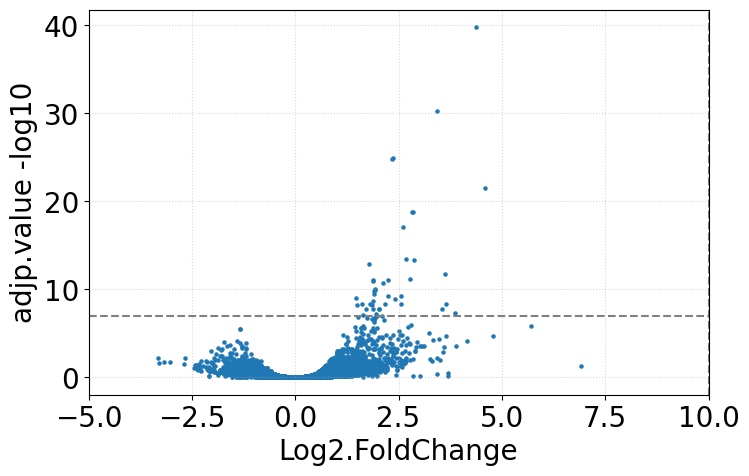

In [309]:
#volcano plot
# Plot, after convertion  y to log10(pvalue)
plt.scatter(x=df_anno['log2FoldChange'],y=df_anno['padj'].apply(lambda x:-numpy.log10(x)),s=5)

# plt.scatter(x=[],y=[], marker="o", color='grey', label= f'n = {grey_genes_n} genes')
# plt.scatter(x=[],y=[], marker="o", color='blue', label= f'n = {blue_genes_n} genes')
# plt.scatter(x=[],y=[], marker="o", color='red', label= f'n = {red_genes_n} genes')

# plt.legend(fontsize = '14')
plt.xlim(-5, 10)
plt.xlabel("Log2.FoldChange")
plt.ylabel("adjp.value -log10")

plt.axvline(-10.2,color="grey",linestyle="--")
plt.axvline(10,color="grey",linestyle="--")
plt.axhline(7,color="grey",linestyle="--")

# title_file = 'volcano_NPC_H3K36me3_MACS3_more_strict'
# plt.savefig(file_directory+'3) output/'+title_file+'.svg')